In [1]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score,
    homogeneity_completeness_v_measure,
)  # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering  # а также другие алгоритмы

/tmp/ipykernel_80544/4137226056.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
DATA_PATH = "../data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(x = X[:, 0], y = X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

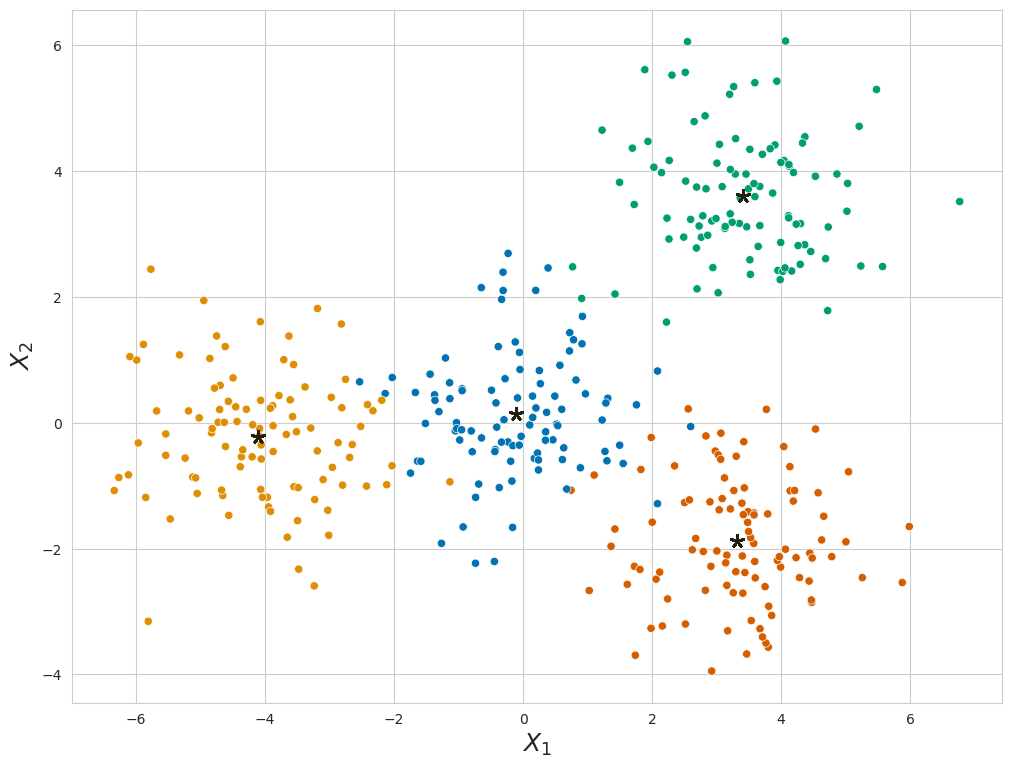

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [6]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, stop_iter_after=None, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
            :param stop_iter_after: stop algorithm after repeatedly receiving 0 updates on centroids (convergence)
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
        self.stop_iter_after = stop_iter_after
        self.iterations_to_convergence = None

    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        centroids_dists = [] # store dists to understand when we reach convergence

        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            
            dists = []
            centroids_prev = centroids
            
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            if np.array(centroids).shape == np.array(centroids_prev).shape: # check here because sometimes it failed with other shape (on iter 547)
                centroids_dists.append(np.linalg.norm(np.array(centroids)- np.array(centroids_prev))) # compute euclidian dist between centroids (i.e. measure of how they changed since last iter)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                print(f"Iteration: {_}") # print iter num if we visualize
                print(f"Previous iteration centriod diff: {centroids_dists[-1]:.5f}")
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()

            if self.stop_iter_after and \
                len(centroids_dists) > self.stop_iter_after  and \
                sum(centroids_dists[-self.stop_iter_after:]) == 0:
                # if last n dists were zeros than we store changepoin iter at self.iterations_to_convergence
                self.iterations_to_convergence = _ - self.stop_iter_after
                if self.visualize:
                    print(f"Stopped iterating at {self.iterations_to_convergence}")
                break
                
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """

        dists = np.linalg.norm(X[:,None] - self.centroids[None,], axis=2)
        cluster_labels = np.linalg.norm(X[:,None] - self.centroids[None,], axis=2).argmin(axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """


        dist = np.linalg.norm(X - centroid, axis=-1)
        
        return dist.reshape(-1, 1)
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

- Random `init`

In [7]:
# MyKMeans(4, stop_iter_after=5, visualize=True).fit(X)

- Sample `init`

In [8]:
# MyKMeans(4, init="sample", stop_iter_after=5, visualize=True).fit(X)

In [9]:
#fitted_random = MyKMeans(4, init="random", stop_iter_after=5).fit(X)
#fitted_random.predict(X)

- Lets check two init methods running multiple simulations

In [10]:
convergence_dct = {"random": [], "sample": []}

for _ in range(100):
    fitted_random = MyKMeans(4, init="random", stop_iter_after=15).fit(X)
    fitted_sample = MyKMeans(4, init="sample", stop_iter_after=15).fit(X)
    convergence_dct['random'].append(fitted_random.iterations_to_convergence)
    convergence_dct['sample'].append(fitted_sample.iterations_to_convergence)

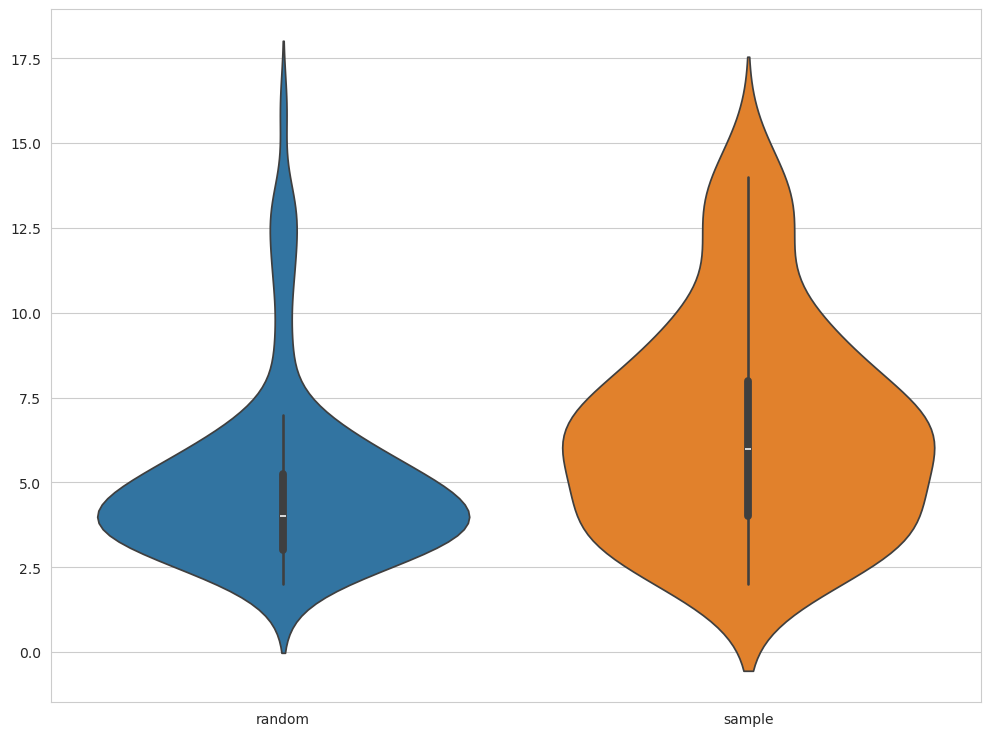

In [11]:
sns.violinplot(convergence_dct);

In [12]:
print(np.median(convergence_dct['random']))
print(np.median(convergence_dct['sample']))

4.0
6.0


In terms of convergence random method seem to be tiny bit better (less time to run)

- Let's check their silhouette_score

In [13]:
fitted_random = MyKMeans(4, init="random", stop_iter_after=15).fit(X)
fitted_sample = MyKMeans(4, init="sample", stop_iter_after=15).fit(X)

In [14]:
print(f'init_method - random: {silhouette_score(X, fitted_random.predict(X))}\ninit_method - sample {silhouette_score(X, fitted_sample.predict(X))}')

init_method - random: 0.5646453226906317
init_method - sample 0.5643117184043004


silhouette_score is identical

- To sum up, this two init methods have identical ability to separate clusters, however, random init seems to comvergent a little faster then sample method

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* distance (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [15]:
data = load_digits()
X, y = data.data, data.target

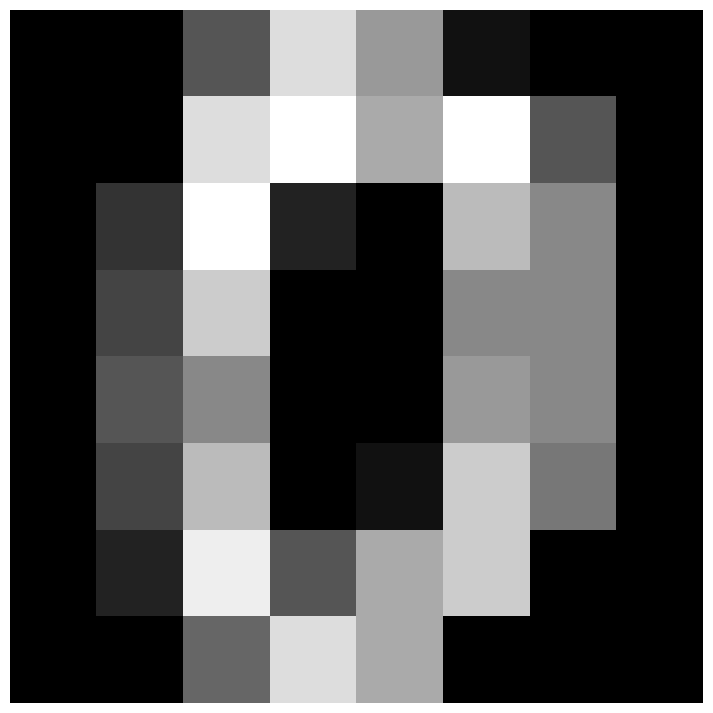

In [16]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`).

In [45]:
def algorithm_selection(
    X, distances, algorithms, n_clusters, metrics=None, true_labels=None
) -> pd.DataFrame:

    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param true_labels: true labels
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    if metrics is None and true_labels is not None:
        metrics = ["homogenity", "completeness", "v_measure"]

    if metrics is not None:
        full_keys_list = ["distance", "linkage", "silhouette"] + metrics
    else:
        full_keys_list = ["distance", "linkage", "silhouette"]

    compare_dct = {
        'distance': [],
        'linkage': [],
        'silhouette': [] # primary "default" metric
    }

    if true_labels is not None: 
        compare_dct['homogenity'] = []
        compare_dct['completeness'] = []
        compare_dct['v_measure'] = []

    for dist in distances:
        for alg in algorithms:
            compare_dct["distance"].append(dist)
            compare_dct["linkage"].append(alg)

            clust = AgglomerativeClustering(
                n_clusters, 
                metric=dist, 
                linkage=alg)

            predicted_clust = clust.fit_predict(X)
            silhouette = silhouette_score(X, predicted_clust)
            compare_dct["silhouette"].append(silhouette)

            if true_labels is not None:
                homogenity, completeness, v_measure = (
                    homogeneity_completeness_v_measure(true_labels, predicted_clust)
                )

                compare_dct["homogenity"].append(homogenity)
                compare_dct["completeness"].append(completeness)
                compare_dct["v_measure"].append(v_measure)

    for k in tuple(compare_dct.keys()):
        if k not in full_keys_list:
            compare_dct.pop(k, None)

    compare_dataframe = pd.DataFrame(compare_dct)

    return compare_dataframe

In [18]:
algorithms = ["complete", "average", "single"]
distances = ["euclidean", "l1", "l2", "manhattan", "cosine"]
metrics = ["v_measure"]

- Full table

In [19]:
df = algorithm_selection(X, distances, algorithms, n_clusters=10, true_labels=y)
df

distance   linkage  silhouette  homogenity  completeness  v_measure
0   euclidean  complete    0.119271    0.590549      0.637772   0.613253
1   euclidean   average    0.146625    0.655393      0.782342   0.713263
2   euclidean    single   -0.133621    0.005056      0.273755   0.009929
3          l1  complete    0.140183    0.646372      0.686109   0.665648
4          l1   average    0.089217    0.566751      0.778942   0.656117
5          l1    single   -0.166627    0.005102      0.276237   0.010019
6          l2  complete    0.119271    0.590549      0.637772   0.613253
7          l2   average    0.146625    0.655393      0.782342   0.713263
8          l2    single   -0.133621    0.005056      0.273755   0.009929
9   manhattan  complete    0.140183    0.646372      0.686109   0.665648
10  manhattan   average    0.089217    0.566751      0.778942   0.656117
11  manhattan    single   -0.166627    0.005102      0.276237   0.010019
12     cosine  complete    0.088021    0.528727      0.577415   0.551999
13     cosine   average    0.129526    0.648268      0.808762   0.719676
14     cosine    single   -0.158250    0.005050      0.273389   0.009916

- Let's only take silhouette and v_measure as measure of both homogenity and completeness and sort df

In [20]:
df = algorithm_selection(X, distances, algorithms, n_clusters=10, metrics=metrics, true_labels=y)
df.sort_values(["silhouette", "v_measure"], ascending=[False, False]).reset_index(drop=True)

distance   linkage  silhouette  v_measure
0   euclidean   average    0.146625   0.713263
1          l2   average    0.146625   0.713263
2          l1  complete    0.140183   0.665648
3   manhattan  complete    0.140183   0.665648
4      cosine   average    0.129526   0.719676
5   euclidean  complete    0.119271   0.613253
6          l2  complete    0.119271   0.613253
7          l1   average    0.089217   0.656117
8   manhattan   average    0.089217   0.656117
9      cosine  complete    0.088021   0.551999
10  euclidean    single   -0.133621   0.009929
11         l2    single   -0.133621   0.009929
12     cosine    single   -0.158250   0.009916
13         l1    single   -0.166627   0.010019
14  manhattan    single   -0.166627   0.010019

- To sum up, average linkage seems to be the best, according to metrics chosen and distances euclidean and l2

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [21]:
fc_data = pd.read_csv(join(DATA_PATH, "flow_c_data.csv"), index_col=0)

In [22]:
fc_data.shape

(10000, 9)

- 10k observations, 9 features

In [23]:
fc_data

FSC-A     SSC-A    HLA-DR       CD3      CD45      CD14      CD56  \
0     0.722199  0.154232  0.494449  0.512853  4.057328  1.019255  4.007273   
1     0.751073  0.114618  4.671924  0.822042  4.933149  0.159388 -0.216407   
2     1.108188  0.150011 -0.422857  4.006353  5.616384  0.519223  0.783077   
3     0.553310  0.119929  0.345968  3.332310  5.260935  1.481229  0.264846   
4     0.774884  0.076984  4.984963  0.885501  4.562367  0.217117  0.086279   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.180762  0.441445  2.437344  1.526085  4.455114  4.880495  0.347480   
9996  0.768279  0.111863  0.812236  4.254496  5.008437  1.303261 -0.130244   
9997  1.314964  0.233584  4.144130  1.311947  5.340263  1.598675 -0.287353   
9998  0.894135  0.137300 -0.226186  0.246804  4.430212  0.457881  2.404284   
9999  0.826941  0.186522 -0.243523  0.606306  4.466970  0.104687  3.738260   

          CD19     CD11c  
0    -1.406912  0.384406  
1     6.034845  0.577039  
2    -0.318668 -0.493832  
3     0.694883  3.416960  
4     5.563345  0.471591  
...        ...       ...  
9995 -0.591343  2.857737  
9996  0.344169 -0.626795  
9997 -0.887078  4.369294  
9998 -0.112999  0.069239  
9999 -0.441455  0.378331  

[10000 rows x 9 columns]

In [24]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

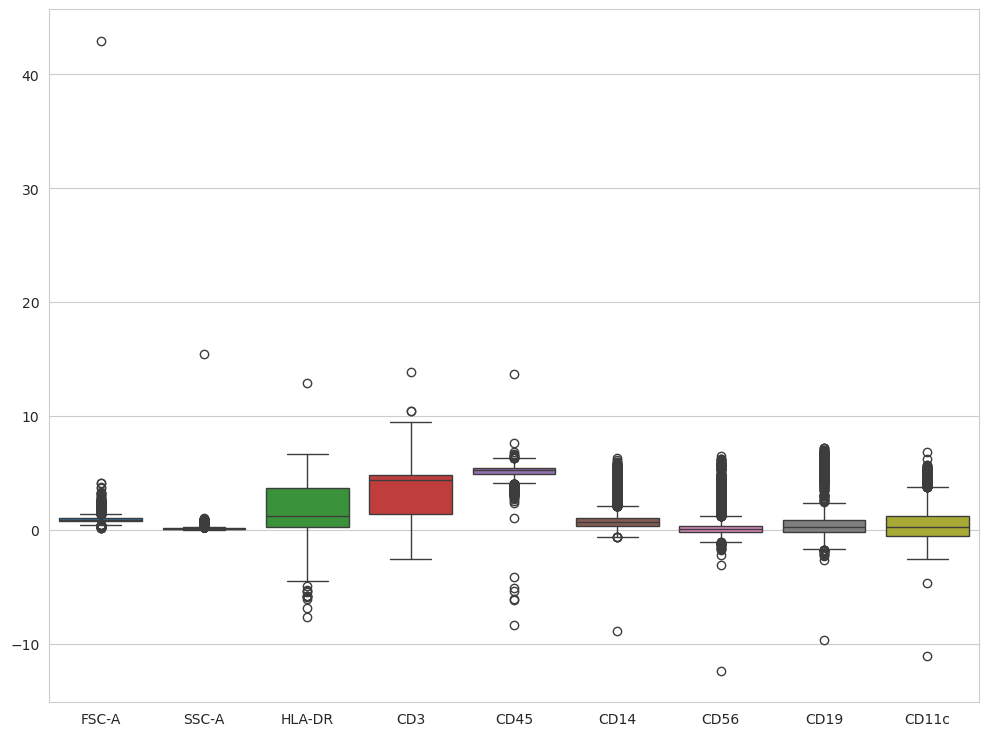

In [25]:
sns.boxplot(fc_data);

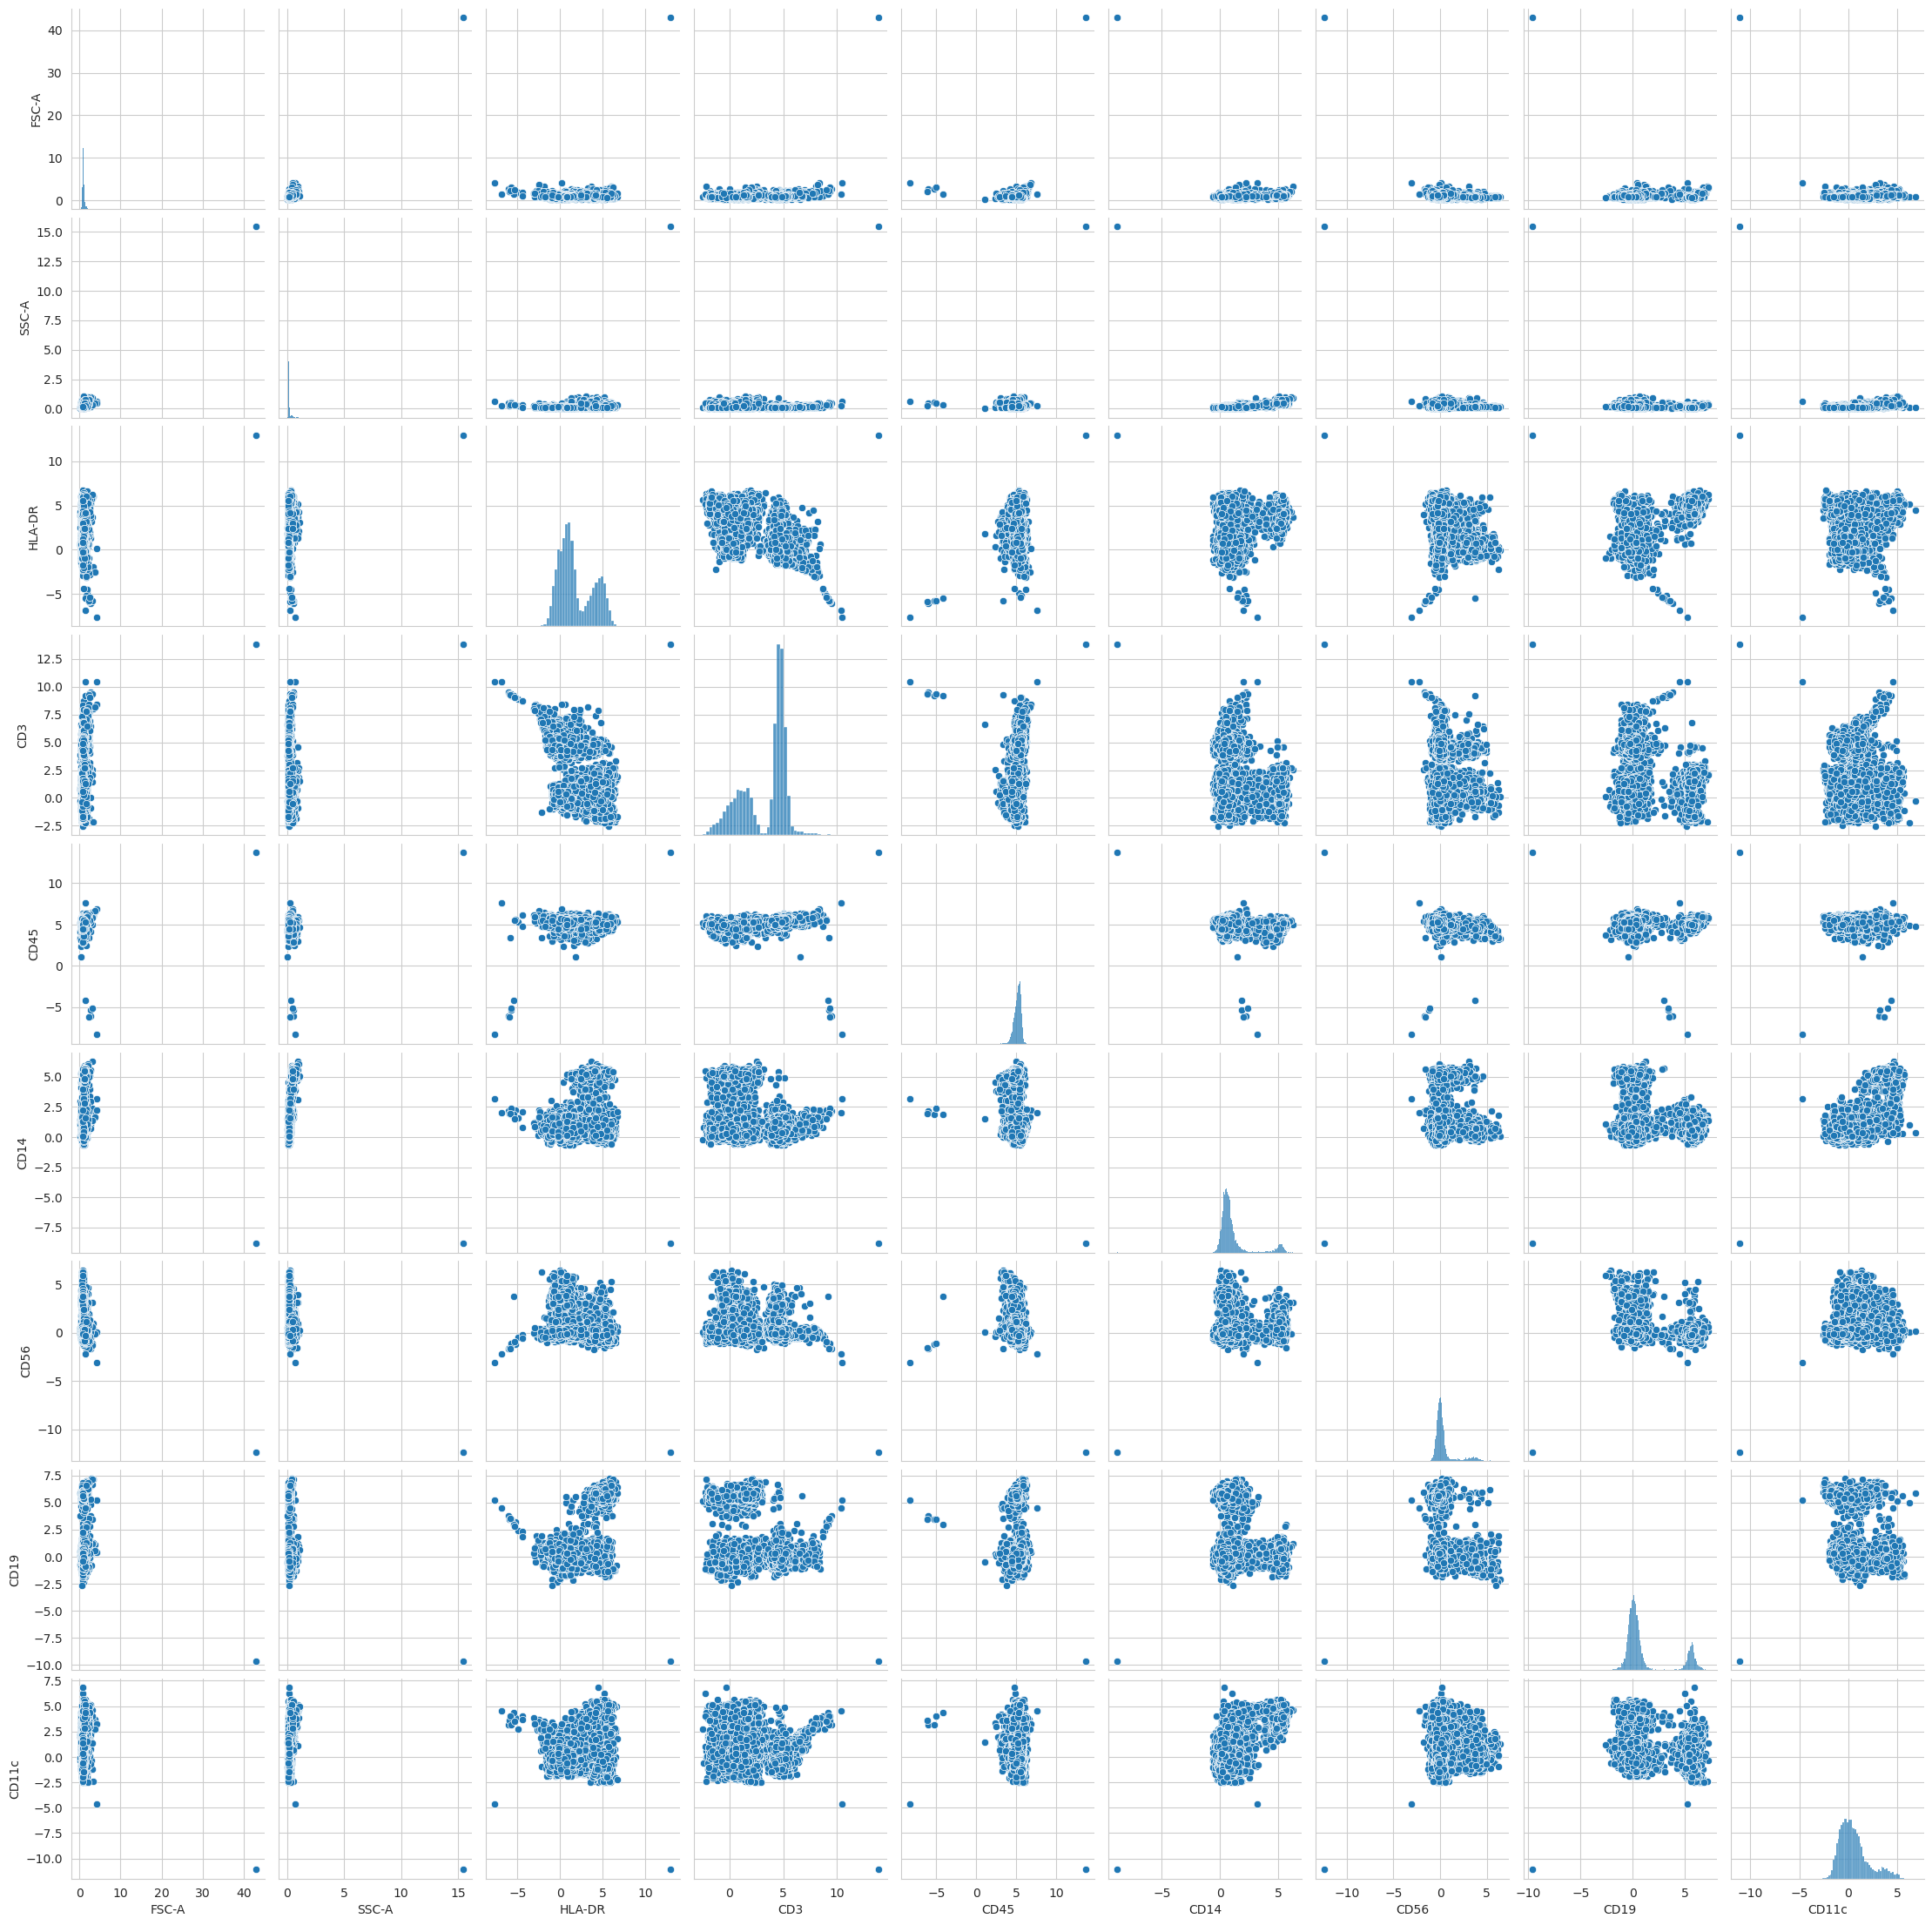

In [26]:
sns.pairplot(fc_data);

We see some obvious outliers here and abundant bimodality . It's probably better to filter outliers

In [27]:
for col in fc_data:
    q_low = fc_data[col].quantile(0.005)
    q_hi = fc_data[col].quantile(0.995)

    fc_data = fc_data[(fc_data[col] < q_hi) & (fc_data[col] > q_low)]

In [28]:
fc_data.shape

(9126, 9)

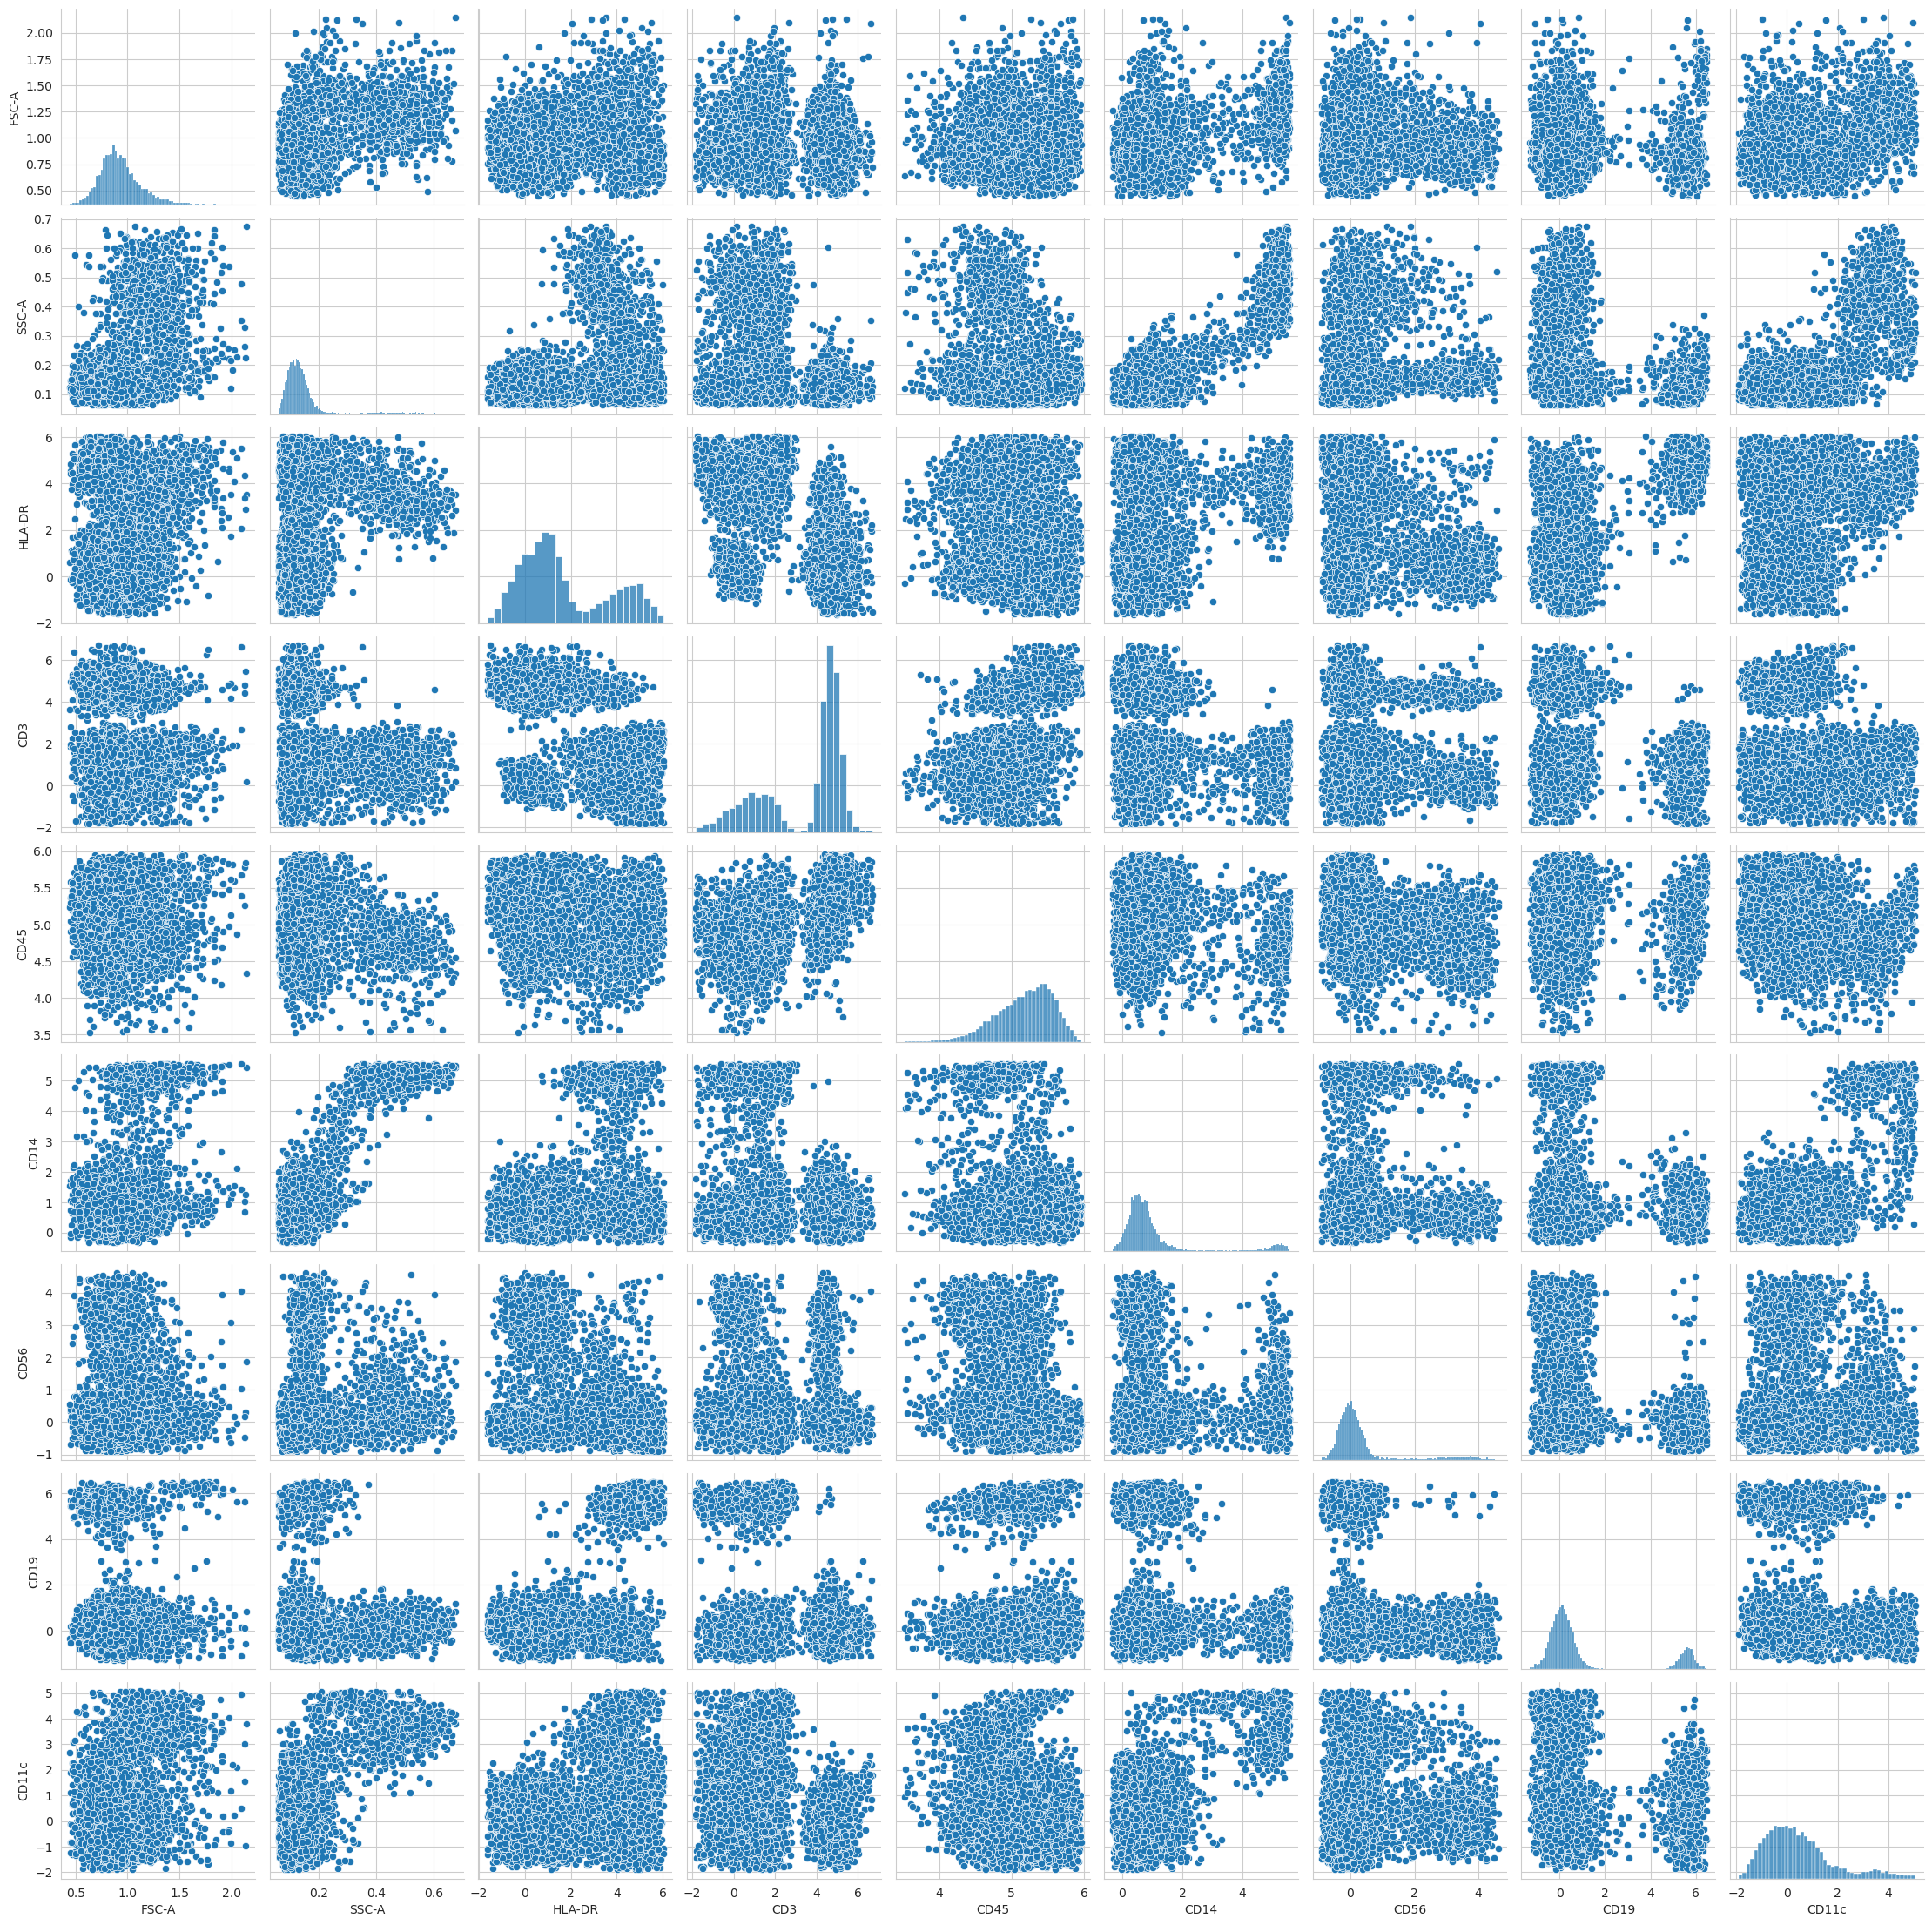

In [29]:
sns.pairplot(fc_data);

- That data look way better, and we've lost only < 10% of data

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [30]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

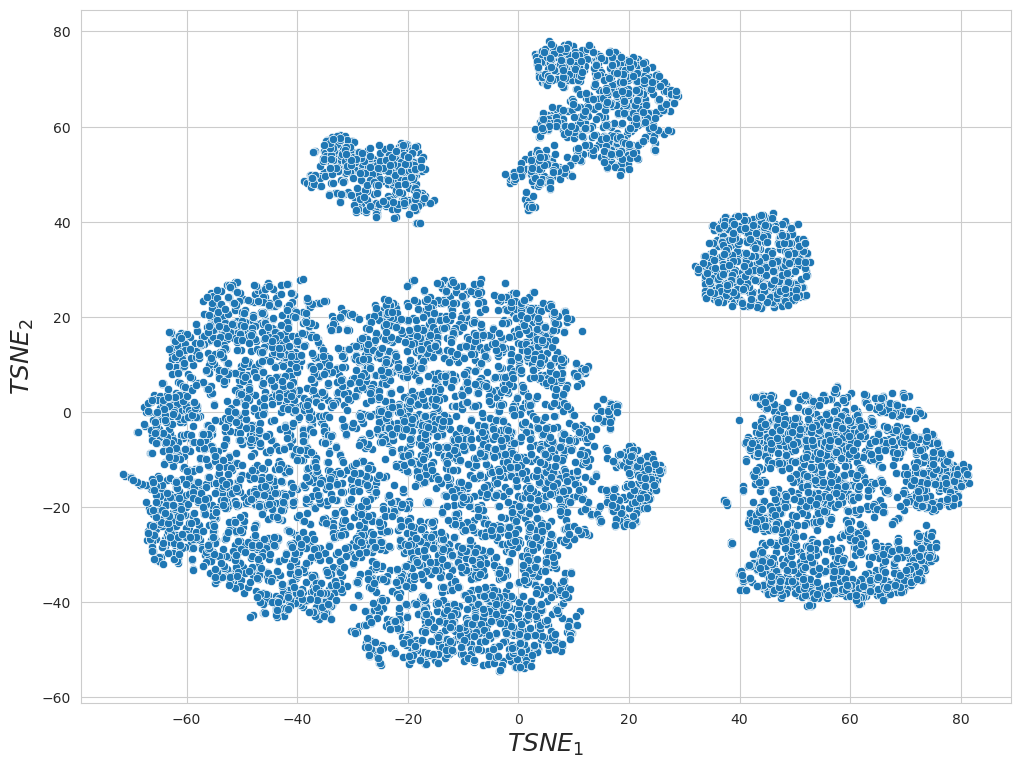

In [31]:
tsne_res = plot_tsne(fc_data)

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

- AgglomerativeClustering + hyperparams tuning

In [48]:
compar_df = pd.DataFrame(columns=['distance', 'linkage', 'silhouette', 'n_clusters'])

for n_clusters in range(2, 8):
    df = algorithm_selection(fc_data, distances, algorithms, n_clusters=n_clusters)
    df['n_clusters'] = n_clusters
    compar_df = pd.concat([compar_df, df])

In [50]:
compar_df.sort_values(["silhouette"], ascending=[False]).reset_index(drop=True).head(10)

distance   linkage  silhouette n_clusters
0  euclidean   average    0.629671          3
1         l2   average    0.629671          3
2  manhattan   average    0.629641          3
3     cosine  complete    0.629641          3
4         l1   average    0.629641          3
5         l1  complete    0.629634          3
6  manhattan  complete    0.629634          3
7     cosine   average    0.629407          3
8         l2  complete    0.626906          4
9  euclidean  complete    0.626906          4

In [55]:
agg = AgglomerativeClustering(
    4, metric="l2", linkage='complete'
)

array([[ 55.69467644, -20.7262995 ],
       [-51.30538421, -16.11440656],
       [-19.07796399,  27.63957446],
       ...,
       [  3.9813711 ,  48.25613259],
       [ 43.73217818,  29.79382088],
       [ 48.83858845,  33.24798041]])

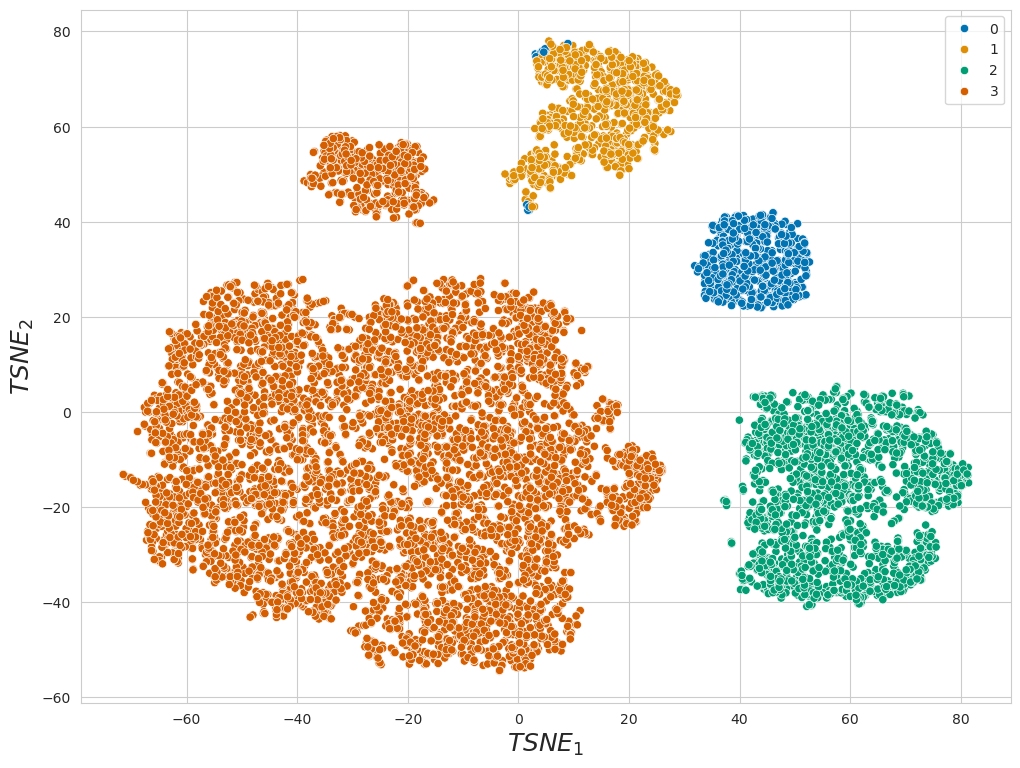

In [56]:
plot_tsne(fc_data, n_iter=1000, perplexity=40, color=agg.fit_predict(fc_data))

- K-means

In [36]:
kmean_scores = {}

fitted_k_means= KMeans(n_clusters=5).fit(fc_data)
k_means_prediction = fitted_k_means.predict(fc_data)

array([[ 55.69467644, -20.7262995 ],
       [-51.30538421, -16.11440656],
       [-19.07796399,  27.63957446],
       ...,
       [  3.9813711 ,  48.25613259],
       [ 43.73217818,  29.79382088],
       [ 48.83858845,  33.24798041]])

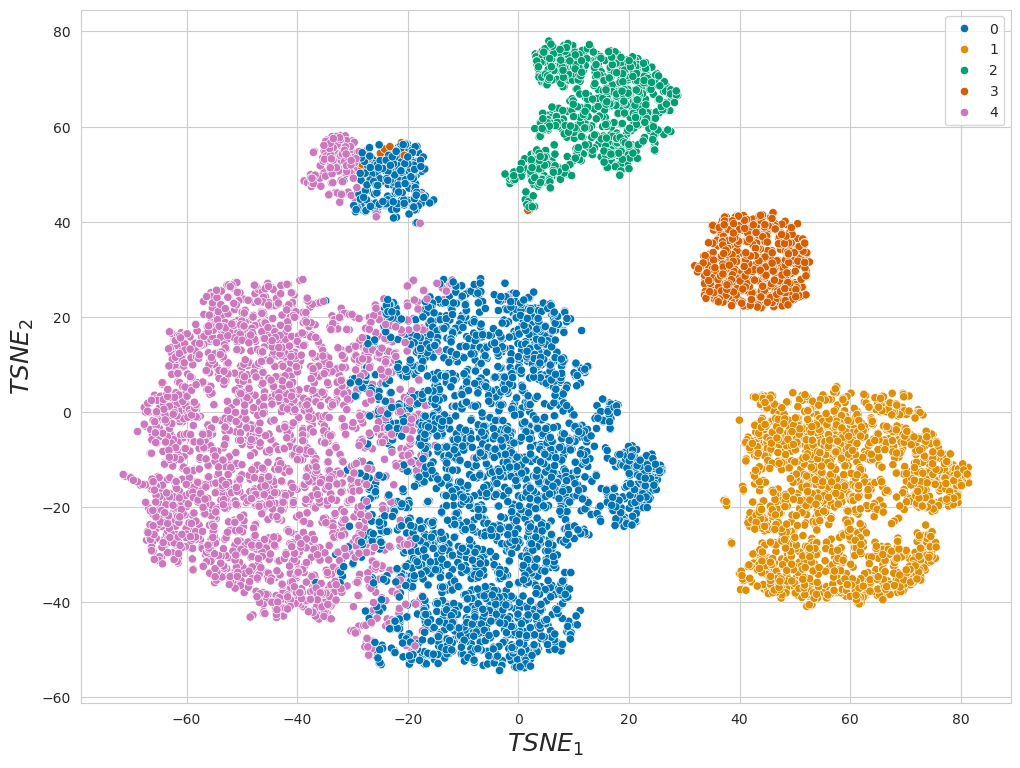

In [39]:
plot_tsne(fc_data, n_iter=1000, perplexity=40, color=k_means_prediction);

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Almost. Yet, we know that TSNE is for dataviz only and does not reflect clusters. Also we had bimodality in data

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Для начала нарисуем все это безобразие:

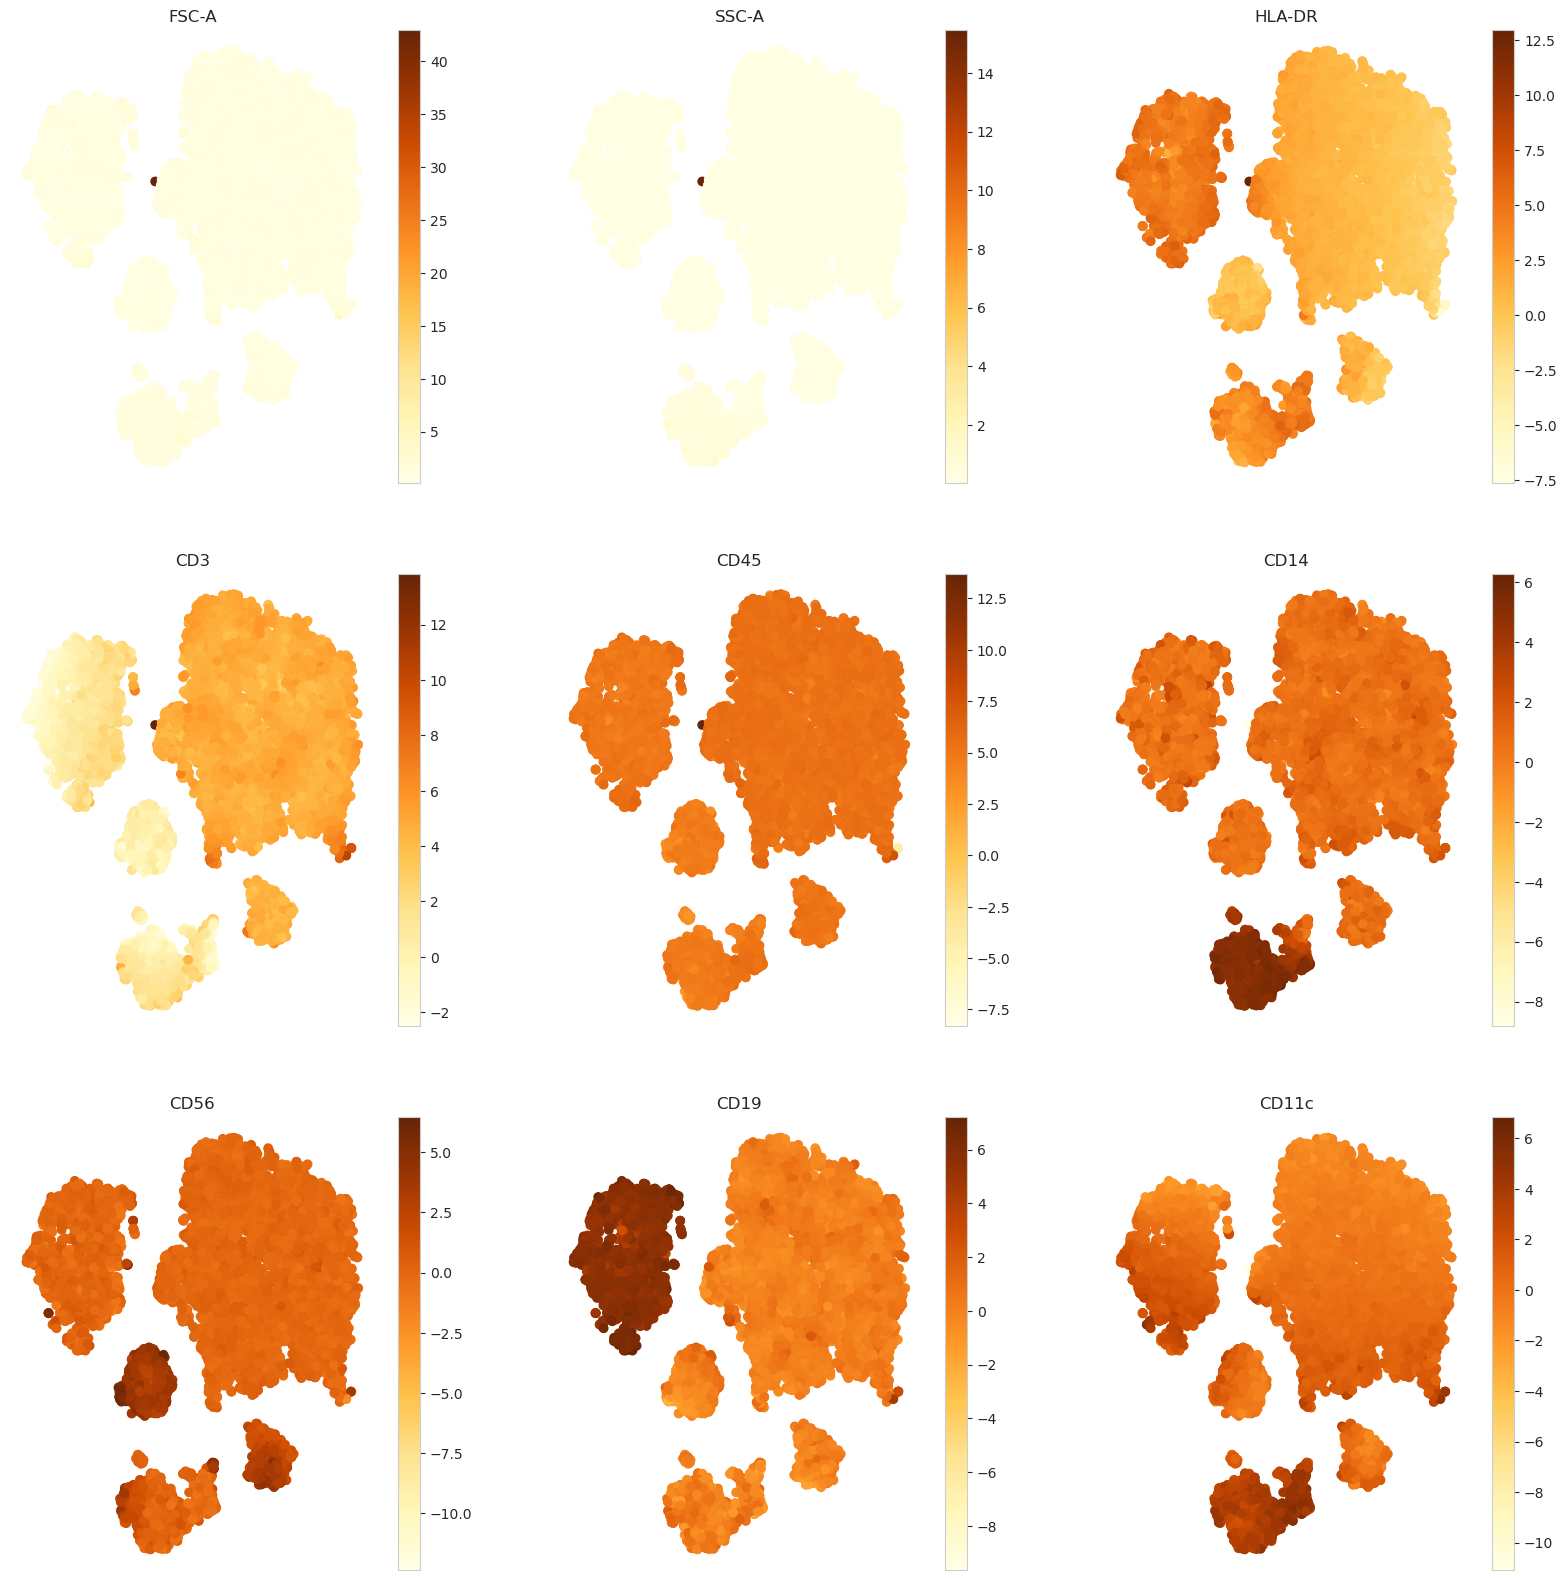

In [ ]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [ ]:
cell_type_cluster_map = {0: "YOUR SOLUTION", 
                         1: "YOUR SOLUTION", 
                         2: "YOUR SOLUTION", 
                         3: "YOUR SOLUTION"}

In [ ]:
labeled_fc_data = fc_data.assign(Population=clust.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

NameError: name 'clust' is not defined

Посчитайте, как распределены типы клеток:

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

#### 3.4. Атоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Хочу собраться с друзьями на песчаной косе на реке-Оке в Пущино. Что-то приличных фоток найти не могу, но там хорошо: река и песок

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**